In [1]:
from fastai2.text.all import *

## Create databunch form LM

In [2]:
BPTT=10
BS=64

EN_FILE = Path('data/en-clean.txt')
EN_TEXT = EN_FILE.read()[1:].replace('\n', '').replace('  ', ' ')

In [3]:
len(EN_TEXT)

1039052

In [4]:
toks = tokenize1(EN_TEXT)

In [5]:
toks[:10]

(#10) ['xxbos','the','project','gutenberg','ebook','of','peter','pan',',','by']

In [6]:
vocab = make_vocab(Counter(toks), min_freq=3, max_vocab=4000)

len(vocab)

4008

In [7]:
vocab[:15]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 ',',
 '.',
 'the',
 'and',
 'to',
 'a']

In [8]:
# arbitrary way of splitting text into 'examples', would probably be better to split by chapters
# or something along these lines but shouldn't make much of a difference
txts = np.array_split(EN_TEXT.split(), 100)

In [9]:
dblock = DataBlock(blocks=(TextBlock(vocab, is_lm=True)), splitter=RandomSplitter(seed=42))

In [10]:
dbunch_lm = dblock.databunch(txts, seq_len=BPTT, bs=BS) 

In [11]:
dbunch_lm.one_batch()[0].shape

torch.Size([64, 10])

## Train LM

In [12]:
WD=1e-7

def opt(params, lr):
    return Adam(params, lr, mom=0.8, sqr_mom=0.99)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

config = dict(
    emb_sz=100,
    n_hid=1024,
    n_layers=3,
    input_p=drops[0],
    hidden_p=drops[1],
    weight_p=drops[2],
    embed_p=drops[3])

awd_lstm_lm_config.update(config)

learn = language_model_learner(
    dbunch_lm,
    AWD_LSTM,
    opt_func=opt,
    pretrained=False,
    config=awd_lstm_lm_config,
    drop_mult=0.2,
    metrics=[accuracy, Perplexity()]
)

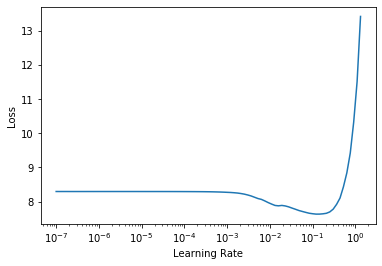

In [13]:
learn.lr_find()

In [14]:
learn.fit(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.938494,5.639233,0.090582,281.246826,00:11
1,5.551490,5.306964,0.136024,201.736908,00:11
2,5.286977,5.029879,0.169900,152.914444,00:11
3,5.045285,4.882214,0.186024,131.922424,00:11
4,4.917571,4.737856,0.206836,114.189163,00:11


In [15]:
learn.save('5epochs')

## Calculate loss given embeddings

In [44]:
learn = learn.load('5epochs')

In [22]:
preds, targs = learn.get_preds()

AttributeError: 'L' object has no attribute 'softmax'

For the time being I get an error as above - will implement manual loss calculation and replace this once it gets fixed ([github issue](https://github.com/fastai/fastai2/issues/35))

In [45]:
def loss():
    preds = []
    targs = []

    learn.model.eval()
    with torch.no_grad():
        for b in learn.dbunch.valid_dl:
            preds.append(learn.model(b[0])[0])
            targs.append(b[1])

    preds = torch.cat(preds, 1)
    targs = torch.cat(targs, 1)
    
    return CrossEntropyLossFlat()(preds, targs).item(), accuracy(preds,targs).item()

In [46]:
emb_layer = learn.model[0].encoder

In [47]:
emb_layer.weight.shape

torch.Size([4008, 100])

In [48]:
loss()

(4.737521171569824, 0.2075829803943634)

In [49]:
emb_layer_weights = emb_layer.weight.clone()

In [50]:
emb_layer.weight[:15].zero_();

In [51]:
loss()

(5.2834153175354, 0.12661105394363403)

In [52]:
emb_layer.weight = nn.Parameter(emb_layer_weights)

In [53]:
loss()

(4.737521171569824, 0.2075829803943634)